- load all api keys from .env file

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

### 1. Bulding State and Graph

- Each node can receive the current State as input and output an update to the state.
- reducer function = add_messages (appends to list of msgs rather than overriting it)

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### 2. Using Tools

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

serper = GoogleSerperAPIWrapper()

tool_search =Tool(
        name = "search",
        func = serper.run,
        description = "If required make an online search to find the answer"
    )


example tool use:

In [15]:
serper.run("Whats the weather in Vellore, Tamil Nadu now?")

'90°F'

In [4]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

import nest_asyncio
nest_asyncio.apply()

async_browser =  create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
playwright_tools = toolkit.get_tools()

for tool in playwright_tools:
    print(f"{tool.name} : {tool}")

click_element : async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\KRISTINE\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
navigate_browser : async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\KRISTINE\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
previous_webpage : async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\KRISTINE\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
extract_text : async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\KRISTINE\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
extract_hyperlinks : async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\KRISTINE\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
get_elements : async_brow

example tool use:

In [16]:
tool_dict = {tool.name:tool for tool in playwright_tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")
    
await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})
# await is used so that after first task finished, only then 2nd task should be done

print(text)

Breaking News, Latest News and Videos | CNN CNN values your feedback 1. How relevant is this ad to you? 2. Did you encounter any technical issues? Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues Ad never loaded Ad prevented/slowed the page from loading Content moved around while ad loaded Ad was repetitive to ads I've seen previously Other issues Cancel Submit Thank You! Your effort and contribution in providing this feedback is much
                                        appreciated. Close Ad Feedback Close icon US World Politics Business Health Entertainment Style Travel Sports Science Climate Weather Ukraine-Russia War Israel-Hamas War Games More US World Politics Business Health Entertainment Style Travel Sports Science Climate Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV Subscribe Sign in My Account Settings Newsletters Topics yo

In [5]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o-mini")

tools = [tool_search] + playwright_tools

llm_with_tools = llm.bind_tools(tools)


### 3. Creating a node (chatbot node)

-  chatbot node function takes the current State as input and returns a dictionary containing an updated messages
- add_messages function in State will append the LLM's response messages to whatever messages are already in the state.

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition

def chatbot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools = tools))
# node_name, function_name


### 4. Adding edges

- START - entry point, where to start each time its run
- END - exit point, where graph should finish execution

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

### 5. Compiling and Visualizing the graph

- before running the graph we need to compile it

In [17]:
graph = graph_builder.compile()

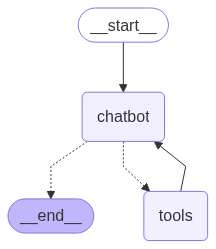

In [9]:
from IPython.display import Image, display_json
display(Image(graph.get_graph().draw_mermaid_png()))

### 6. Chat Interface

In [ ]:
import gradio as gr 

def chat(user_input, history):
    initial_state = State(messages = [{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='tell me about the top 5 products on amazon', additional_kwargs={}, response_metadata={}, id='8b19dce7-8987-4015-85b3-078affb1b226'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4l3g7GGVXidnflgqT9M0xOLl', 'function': {'arguments': '{"__arg1":"top selling products on amazon"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 281, 'total_tokens': 300, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1YvHdyQI2WJOap3vYAZEzvxhqclb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69682008-59ae-4112-9ffb-cfde4a7843fc-0', tool_calls=[{'name': 'search', 'args': {

### 6. MEMORYY !!!

memory based on thread_id, we can make this as user_id

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [20]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.
